In [1]:
import pandas as pd
df = pd.read_csv('italian_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:57:18.931000,LEC,16,0 days 00:01:28.179000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:29.989000,...,True,Ferrari,0 days 00:55:50.494000,2024-09-01 13:03:34.413,1,2.0,False,NaN,False,False
1,0 days 00:58:44.327000,LEC,16,0 days 00:01:25.396000,2.0,1.0,NaN,NaN,0 days 00:00:27.707000,0 days 00:00:29.265000,...,True,Ferrari,0 days 00:57:18.931000,2024-09-01 13:05:02.850,1,2.0,False,NaN,False,True
2,0 days 01:00:09.506000,LEC,16,0 days 00:01:25.179000,3.0,1.0,NaN,NaN,0 days 00:00:27.679000,0 days 00:00:29.001000,...,True,Ferrari,0 days 00:58:44.327000,2024-09-01 13:06:28.246,1,2.0,False,NaN,False,True
3,0 days 01:01:34.316000,LEC,16,0 days 00:01:24.810000,4.0,1.0,NaN,NaN,0 days 00:00:27.653000,0 days 00:00:28.883000,...,True,Ferrari,0 days 01:00:09.506000,2024-09-01 13:07:53.425,1,2.0,False,NaN,False,True
4,0 days 01:02:58.919000,LEC,16,0 days 00:01:24.603000,5.0,1.0,NaN,NaN,0 days 00:00:27.630000,0 days 00:00:28.790000,...,True,Ferrari,0 days 01:01:34.316000,2024-09-01 13:09:18.235,1,2.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0 days 01:00:20.190000,TSU,22,0 days 00:01:26.665000,3.0,1.0,NaN,NaN,0 days 00:00:27.756000,0 days 00:00:29.819000,...,False,RB,0 days 00:58:53.525000,2024-09-01 13:06:37.444,1,15.0,False,NaN,False,True
1004,0 days 01:01:46.388000,TSU,22,0 days 00:01:26.198000,4.0,1.0,NaN,NaN,0 days 00:00:27.631000,0 days 00:00:29.689000,...,False,RB,0 days 01:00:20.190000,2024-09-01 13:08:04.109,1,15.0,False,NaN,False,True
1005,0 days 01:03:18.629000,TSU,22,0 days 00:01:32.241000,5.0,1.0,NaN,NaN,0 days 00:00:28.736000,0 days 00:00:32.722000,...,False,RB,0 days 01:01:46.388000,2024-09-01 13:09:30.307,1,19.0,True,TRACK LIMITS AT TURN 2 LAP 5,False,True
1006,0 days 01:04:47.102000,TSU,22,0 days 00:01:28.473000,6.0,1.0,NaN,NaN,0 days 00:00:28.426000,0 days 00:00:30.441000,...,False,RB,0 days 01:03:18.629000,2024-09-01 13:11:02.548,1,19.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 53  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              1              18.0          26.500000   
1    ALO              2              13.0          17.666667   
2    BOT              1              34.0          26.000000   
3    COL              1              17.0          26.500000   
4    GAS              2              11.0          17.333333   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0               0.0          0.320755         0.679245  
1               0.0          0.226415         0.773585  
2               0.0          0.365385         0.634615  
3               0.0          0.301887         0.698113  
4               0.0          0.192308         0.807692  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,17.0,0 days 01:20:21.362000,NaN,MEDIUM,17.0,1.0
1,ALB,18.0,NaN,0 days 01:20:46.162000,HARD,1.0,2.0
2,ALO,12.0,0 days 01:13:10.512000,NaN,MEDIUM,13.0,1.0
3,ALO,13.0,NaN,0 days 01:13:35.387000,HARD,2.0,2.0
4,ALO,35.0,0 days 01:46:11.502000,NaN,HARD,24.0,2.0
...,...,...,...,...,...,...,...
56,VER,23.0,NaN,0 days 01:27:41.632000,HARD,1.0,2.0
57,VER,41.0,0 days 01:54:11.181000,NaN,HARD,19.0,2.0
58,VER,42.0,NaN,0 days 01:54:35.133000,MEDIUM,1.0,3.0
59,ZHO,15.0,0 days 01:17:44.783000,NaN,MEDIUM,16.0,1.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,18.0,26.500000,0.000000,0.320755,0.679245
1,ALO,2,13.0,17.666667,0.000000,0.226415,0.773585
2,BOT,1,34.0,26.000000,0.000000,0.365385,0.634615
3,COL,1,17.0,26.500000,0.000000,0.301887,0.698113
4,GAS,2,11.0,17.333333,0.000000,0.192308,0.807692
5,HAM,2,16.0,17.666667,0.000000,0.283019,0.716981
6,HUL,2,6.0,17.333333,0.000000,0.096154,0.903846
7,LEC,1,16.0,26.500000,0.000000,0.283019,0.716981
8,MAG,1,15.0,26.500000,0.000000,0.264151,0.735849
9,NOR,2,15.0,17.666667,0.000000,0.264151,0.735849


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,927


In [9]:
df['Driver'].value_counts()


,count
Driver,
LEC,50
SAI,50
COL,50
MAG,50
ALB,50
RIC,50
ZHO,49
BOT,49
OCO,49


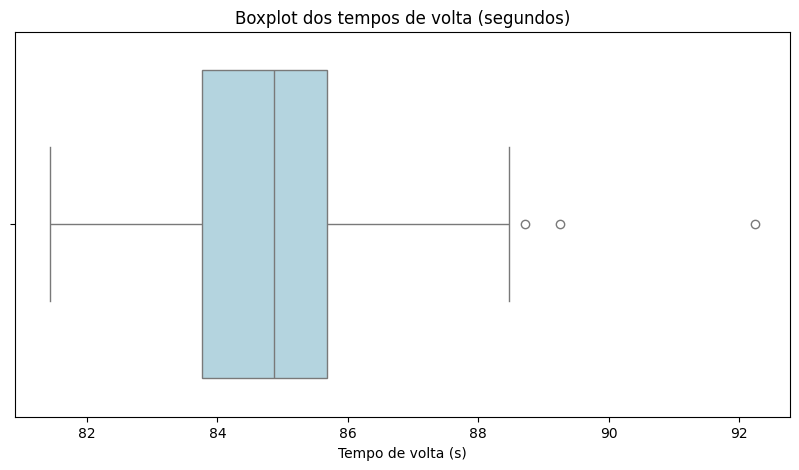

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


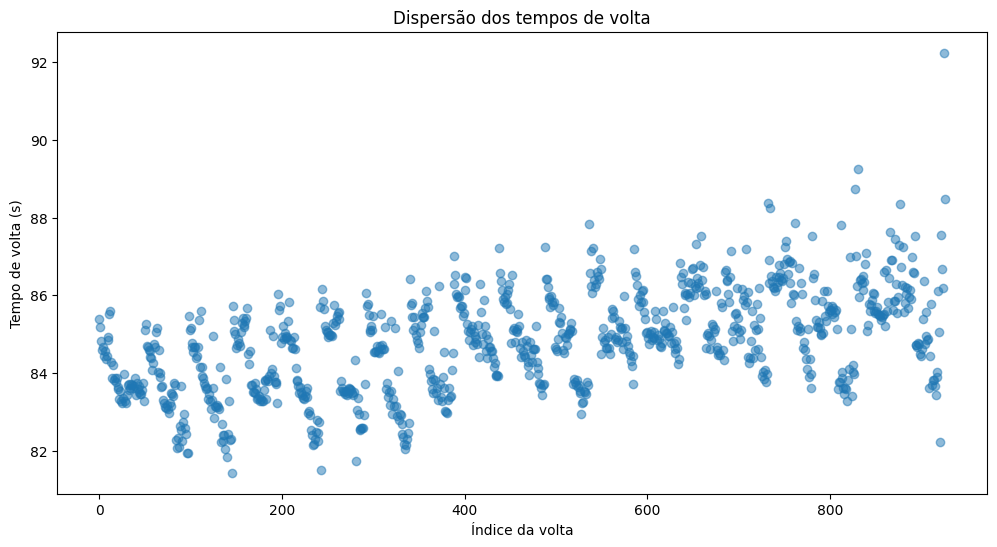

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


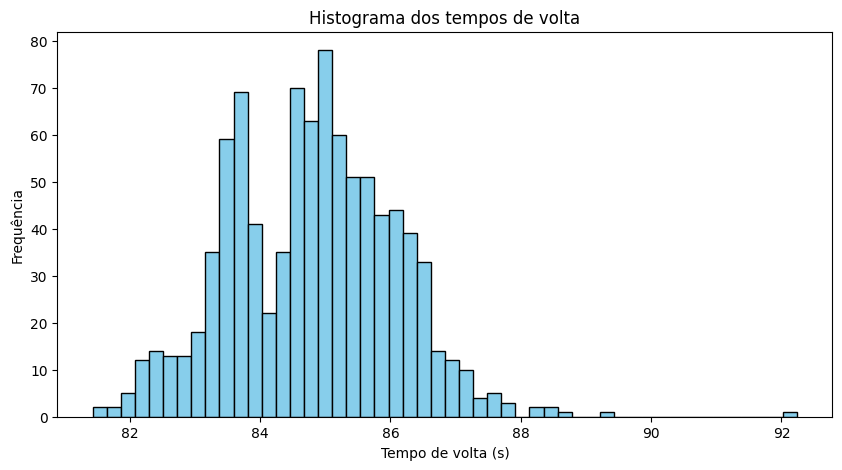

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


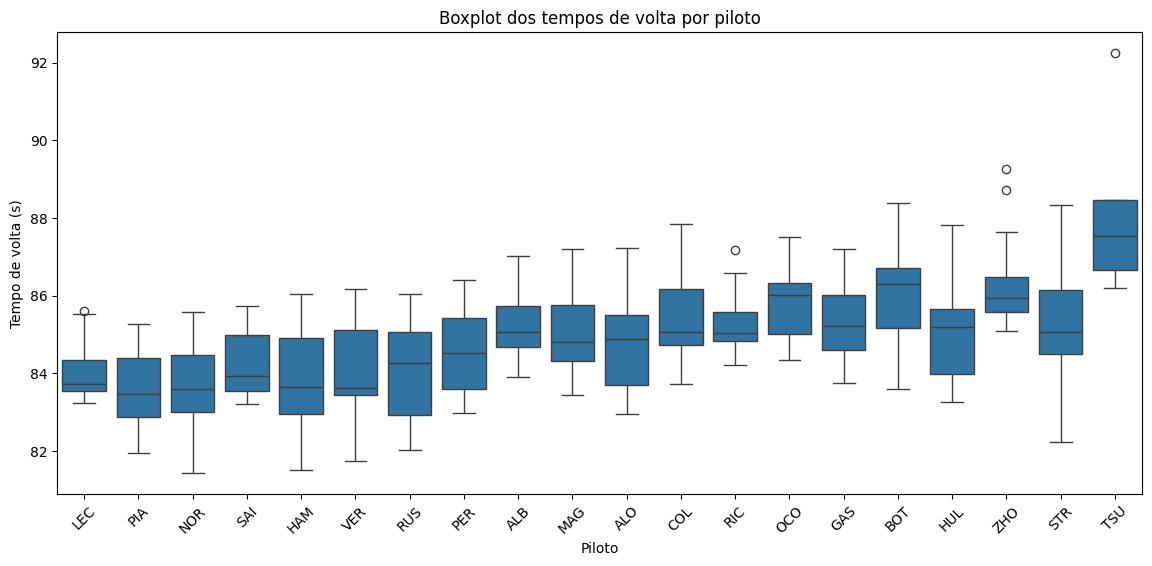

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
NOR   0 days 00:01:21.432000
HAM   0 days 00:01:21.512000
VER   0 days 00:01:21.745000
PIA   0 days 00:01:21.943000
RUS   0 days 00:01:22.036000
STR   0 days 00:01:22.232000
ALO   0 days 00:01:22.944000
PER   0 days 00:01:22.971000
SAI   0 days 00:01:23.219000
LEC   0 days 00:01:23.226000
HUL   0 days 00:01:23.275000
MAG   0 days 00:01:23.437000
BOT   0 days 00:01:23.609000
COL   0 days 00:01:23.728000
GAS   0 days 00:01:23.755000
ALB   0 days 00:01:23.918000
RIC   0 days 00:01:24.219000
OCO   0 days 00:01:24.343000
ZHO   0 days 00:01:25.092000
TSU   0 days 00:01:26.198000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Italia'
race_date = '2024-09-01'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,50,85.174980,0.768067,83.918,87.011,85.0590,3.093,2024,Italia,2024-09-01
1,ALO,48,84.740125,1.035921,82.944,87.236,84.8865,4.292,2024,Italia,2024-09-01
2,BOT,49,86.024020,1.105134,83.609,88.377,86.3100,4.768,2024,Italia,2024-09-01
3,COL,50,85.372160,0.920494,83.728,87.845,85.0665,4.117,2024,Italia,2024-09-01
4,GAS,47,85.323936,0.897483,83.755,87.191,85.2290,3.436,2024,Italia,2024-09-01
5,HAM,48,83.897271,1.183427,81.512,86.043,83.6565,4.531,2024,Italia,2024-09-01
6,HUL,47,85.057745,1.110602,83.275,87.809,85.1940,4.534,2024,Italia,2024-09-01
7,LEC,50,83.949360,0.629429,83.226,85.606,83.7160,2.380,2024,Italia,2024-09-01
8,MAG,50,84.962640,0.902223,83.437,87.205,84.7960,3.768,2024,Italia,2024-09-01
9,NOR,48,83.607604,1.044425,81.432,85.585,83.5910,4.153,2024,Italia,2024-09-01


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,50,85.174980,0.768067,83.918,87.011,85.0590,3.093,2024,Italia,2024-09-01,53.0,True
1,ALO,48,84.740125,1.035921,82.944,87.236,84.8865,4.292,2024,Italia,2024-09-01,53.0,True
2,BOT,49,86.024020,1.105134,83.609,88.377,86.3100,4.768,2024,Italia,2024-09-01,52.0,True
3,COL,50,85.372160,0.920494,83.728,87.845,85.0665,4.117,2024,Italia,2024-09-01,53.0,True
4,GAS,47,85.323936,0.897483,83.755,87.191,85.2290,3.436,2024,Italia,2024-09-01,52.0,True
5,HAM,48,83.897271,1.183427,81.512,86.043,83.6565,4.531,2024,Italia,2024-09-01,53.0,True
6,HUL,47,85.057745,1.110602,83.275,87.809,85.1940,4.534,2024,Italia,2024-09-01,52.0,True
7,LEC,50,83.949360,0.629429,83.226,85.606,83.7160,2.380,2024,Italia,2024-09-01,53.0,True
8,MAG,50,84.962640,0.902223,83.437,87.205,84.7960,3.768,2024,Italia,2024-09-01,53.0,True
9,NOR,48,83.607604,1.044425,81.432,85.585,83.5910,4.153,2024,Italia,2024-09-01,53.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,18.0,26.500000,0.000000,0.320755,0.679245
1,ALO,2,13.0,17.666667,0.000000,0.226415,0.773585
2,BOT,1,34.0,26.000000,0.000000,0.365385,0.634615
3,COL,1,17.0,26.500000,0.000000,0.301887,0.698113
4,GAS,2,11.0,17.333333,0.000000,0.192308,0.807692
5,HAM,2,16.0,17.666667,0.000000,0.283019,0.716981
6,HUL,2,6.0,17.333333,0.000000,0.096154,0.903846
7,LEC,1,16.0,26.500000,0.000000,0.283019,0.716981
8,MAG,1,15.0,26.500000,0.000000,0.264151,0.735849
9,NOR,2,15.0,17.666667,0.000000,0.264151,0.735849


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,50,85.174980,0.768067,83.918,87.011,85.0590,3.093,2024,Italia,2024-09-01,53.0,True,1,18.0,26.500000,0.000000,0.320755,0.679245
1,ALO,48,84.740125,1.035921,82.944,87.236,84.8865,4.292,2024,Italia,2024-09-01,53.0,True,2,13.0,17.666667,0.000000,0.226415,0.773585
2,BOT,49,86.024020,1.105134,83.609,88.377,86.3100,4.768,2024,Italia,2024-09-01,52.0,True,1,34.0,26.000000,0.000000,0.365385,0.634615
3,COL,50,85.372160,0.920494,83.728,87.845,85.0665,4.117,2024,Italia,2024-09-01,53.0,True,1,17.0,26.500000,0.000000,0.301887,0.698113
4,GAS,47,85.323936,0.897483,83.755,87.191,85.2290,3.436,2024,Italia,2024-09-01,52.0,True,2,11.0,17.333333,0.000000,0.192308,0.807692
5,HAM,48,83.897271,1.183427,81.512,86.043,83.6565,4.531,2024,Italia,2024-09-01,53.0,True,2,16.0,17.666667,0.000000,0.283019,0.716981
6,HUL,47,85.057745,1.110602,83.275,87.809,85.1940,4.534,2024,Italia,2024-09-01,52.0,True,2,6.0,17.333333,0.000000,0.096154,0.903846
7,LEC,50,83.949360,0.629429,83.226,85.606,83.7160,2.380,2024,Italia,2024-09-01,53.0,True,1,16.0,26.500000,0.000000,0.283019,0.716981
8,MAG,50,84.962640,0.902223,83.437,87.205,84.7960,3.768,2024,Italia,2024-09-01,53.0,True,1,15.0,26.500000,0.000000,0.264151,0.735849
9,NOR,48,83.607604,1.044425,81.432,85.585,83.5910,4.153,2024,Italia,2024-09-01,53.0,True,2,15.0,17.666667,0.000000,0.264151,0.735849


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoItalia.csv', index=False)
